# Logistic Regression  

---------------

_Code by PJ Cabrera_   

## Project Guide
------------
- [Project Overview](#overview)
- [Introduction and Review](#intro)
- [Data Exploration](#data)
- [Coding Logistic Regression](#code)
- [Logistic Regression in `sklearn`](#sklearn)

<a id = "overview"></a>
## Project Overview  
-------------

I will work through the definition of a Logistic Regression function in `Python`. After a summary of the equations that will be used, and a brief EDA of the "Titanic" data we will be using, you will be asked to define a number of functions which will, in sum, create a Logistic Regression.

A demonstration of `sklearn`'s implementation of Logistic Regression will close the notebook.

I will code functions to do the following:
1. Implement the Logistic Regression Algorithm
    - Calculate the value of the sigmoid function
    - Calculate the gradient of the log-likelihood with respect to $w$
    - Sum the gradients of the log-likelihood with respect to $w$
2. Execute logistic regression, stopping after a particular iteration
3. Determine convergence of the logistic regression algorithm

**Motivation**: Logistic Regression offers a way to to create a fairly interpretable parametic model for binary classification.

**Problem**: Using Logistic Regression, predict whether or not a passenger survived the sinking of the Titanic.

**Data**: The data for today comes from [Kaggle's Titanic Data](https://www.kaggle.com/c/titanic/data)  

Please see above link for a more complete description of the data.

<a id = "intro"></a>

### Introduction and Review

The lectures this week derived all of the equations that used in this assignment.  

Recall that the likelihood for Logistic Regression is given by:

$$p(y_1,\ ...,\ y_n\ |\ x_1,\ ...,\ x_n,\ w)\ =\prod\limits_{i=1}^n\ \sigma_i(y_i \cdot w)$$  

For coding purposes, we need the expression for the gradient of the log-likelihood with respect to $w$:


$$\nabla_w \mathcal{L} = \sum_{i = 1}^n (1 − \sigma_i(y_i \cdot w))\ y_i x_i$$  

Where: $$\sigma_i(y_i \cdot w) = \frac{e^{y_iX_i^Tw}}{1+e^{y_ix_i^Tw}}$$  


<a id = "data"></a>
### Data Exploration

I will analyze data from the Titanic passenger manifest. Demographic and trip information for each passenger is coupled with whether or not they survived the disaster.

Start by examining the data as usual:

In [2]:
# Import the necessary modules and sets a few plotting parameters for display

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Load the data into a `pandas` DataFrame object
tr_path = './titanic/train.csv'
titanic_df = pd.read_csv(tr_path)

# Examine head of df
titanic_df.head(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


#### Dropping nulls.  

The general rules followed below are:  

- If a column consists mostly of missing data, that column probably will not be of much use in prediction.  
- If a column has very few missing values, and enough records to build a model are complete, the records with missing values in that column may be cast out.  


In [4]:

### 1. Drop all of the columns in `titanic_df` which are filled more than 50% with nulls.
### 2. If a column has fewer than 10 missing values:
### ### Drop all of the records with missing data in that column.

### After performing the above drops, what is the shape of the DataFrame?

# Drop all of the columns in `titanic_df` which are filled more than 50% with nulls.
df = titanic_df.loc[:, titanic_df.isnull().mean() < .5]
for column in df.columns:
    # If a column has fewer than 10 missing values:
    if df[column].isnull().sum() < 10:
    # Drop all of the records with missing data in that column.
        df = df.dropna(subset=[column])

df.shape

(889, 11)

Given the fairly large number of values missing from "Age", and the feature's likely relationship with survival, we will create an educated guess for missing passenger ages; computing the ages using a $k$-Nearest-Neighbor algorithm.

Note: In computing values for "age",  "`survival`" will be excluded from the $X$ matrix since that is the value we ultimately plan to predict.

#### KNeighborsRegressor in `sklearn`
Because `sklearn` automatically converts all data to floats before fitting models, it is necessary to encode any and all categorical variables as dummy variables:

In [5]:
### Drop irrelevant categories
titanic_df.drop(['Ticket','Cabin', 'PassengerId', 'Name'], axis=1, inplace=True)
titanic_df = titanic_df.loc[titanic_df['Embarked'].notnull(),:]

### Drop "Survived" for purposes of KNN imputation:
y_target = titanic_df.Survived
titanic_knn = titanic_df.drop(['Survived'], axis = 1)  
titanic_knn.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [6]:
### Adding dummy variables for categorical vars
to_dummy = ['Sex','Embarked']
titanic_knn = pd.get_dummies(titanic_knn, prefix = to_dummy, columns = to_dummy, drop_first = True)

titanic_knn.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


In [7]:
### Splitting data - on whether or not "Age" is specified.

# Training data -- "Age" Not null; "Age" as target
train = titanic_knn[titanic_knn.Age.notnull()]
X_train = train.drop(['Age'], axis = 1)
y_train = train.Age


# Data to impute, -- Where Age is null; Remove completely-null "Age" column.
compute = titanic_knn[titanic_knn.Age.isnull()].drop(['Age'], axis = 1)
print("Data to Compute")
print(compute.head(3))

# import algorithm
from sklearn.neighbors import KNeighborsRegressor

# Instantiate
knr = KNeighborsRegressor()

# Fit
knr.fit(X_train, y_train)

# Create Predictions
computed_ages = knr.predict(compute)

# Add to Df
compute['Age'] = computed_ages
print("\nComputed Ages")
print(compute.head(3))

# Re-combine dataframes
titanic_computed = pd.concat([train, compute], sort = False, axis = 0)

# Return to original order - to match back up with "Survived"
titanic_computed.sort_index(inplace = True)
print("Shape with computed values:", titanic_computed.shape)
print("Shape before computation:", titanic_knn.shape)
titanic_computed.head(7)

Data to Compute
    Pclass  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S
5        3      0      0   8.4583         1           1           0
17       2      0      0  13.0000         1           0           1
19       3      0      0   7.2250         0           0           0

Computed Ages
    Pclass  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S   Age
5        3      0      0   8.4583         1           1           0  47.2
17       2      0      0  13.0000         1           0           1  25.6
19       3      0      0   7.2250         0           0           0  23.0
Shape with computed values: (889, 8)
Shape before computation: (889, 8)


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1
5,3,47.2,0,0,8.4583,1,1,0
6,1,54.0,0,0,51.8625,1,0,1


It would be appropriate to spend more time taking care with the computation of age. For brevity's sake that will not be done here.

#### Brief EDA

First Look at tabulations of categorical variables:

In [8]:
import itertools
# Lists of categorical v. numeric features
categorical = ['Pclass','Sex','Embarked']
numeric = ['Age','SibSp','Parch','Fare']

# Create all pairs of categorical variables, look at distributions
cat_combos = list(itertools.combinations(categorical, 2))
print("All Combos or categorical vars: \n",cat_combos, "\n")
for row, col in cat_combos:
    print("Row Percents: \n",pd.crosstab(titanic_df[row], titanic_df[col], normalize="index"), "\n")
    print("Column Percents: \n", pd.crosstab(titanic_df[row], titanic_df[col], normalize="columns"),"\n---------------\n")

All Combos or categorical vars: 
 [('Pclass', 'Sex'), ('Pclass', 'Embarked'), ('Sex', 'Embarked')] 

Row Percents: 
 Sex       female      male
Pclass                    
1       0.429907  0.570093
2       0.413043  0.586957
3       0.293279  0.706721 

Column Percents: 
 Sex       female      male
Pclass                    
1       0.294872  0.211438
2       0.243590  0.187175
3       0.461538  0.601386 
---------------

Row Percents: 
 Embarked         C         Q         S
Pclass                                
1         0.397196  0.009346  0.593458
2         0.092391  0.016304  0.891304
3         0.134420  0.146640  0.718941 

Column Percents: 
 Embarked         C         Q         S
Pclass                                
1         0.505952  0.025974  0.197205
2         0.101190  0.038961  0.254658
3         0.392857  0.935065  0.548137 
---------------

Row Percents: 
 Embarked         C         Q         S
Sex                                   
female    0.233974  0.115385  0.650

**Correlation heatmap of the numberic variables**

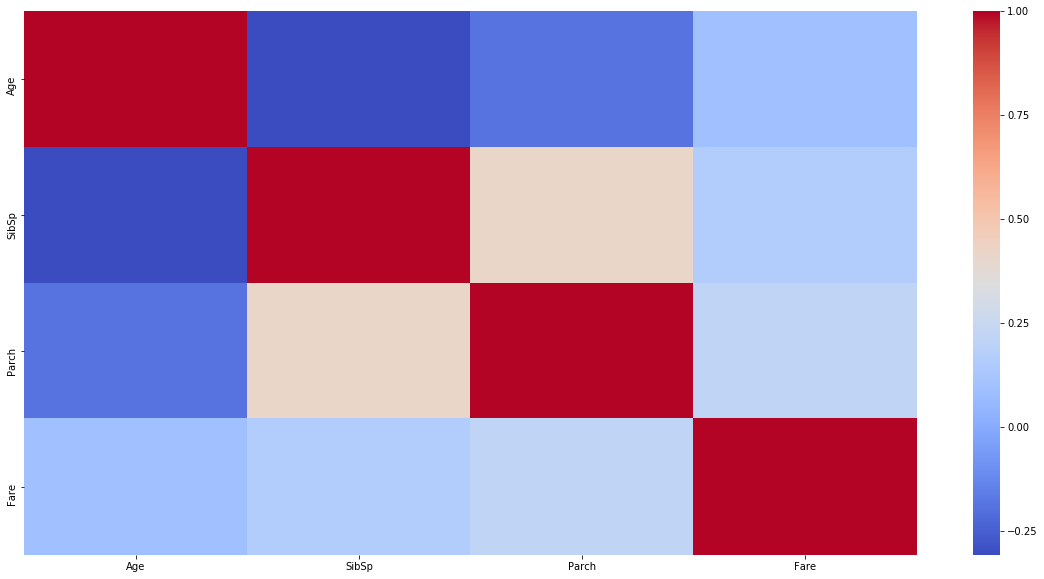

In [9]:
import seaborn as sns
sns.heatmap(titanic_df[numeric].corr(), cmap = "coolwarm");

<a id = "code"></a>
### Coding Logistic Regression

The first function will perform the preprocessing of our data. The steps are:  

**First**: Ensure that the x- and y- matricies have the observations as rows, and features as columns.  
- The x-matrix will be n-rows and d-columns. Where $n>d$
- The y-vector will be a 1-dimensional numpy array of length n.  

**Second**: A column of ones must be added to the x-inputs matrix, increasing its dimensions to n-by-d+1.  

**Third**: Ensure that the y-vector has all values encoded as 1 and -1, NOT 1 and 0.  

**Fourth**: The initial vector of weights should be created, a vector of length d+1 of all 0's (Hint: look at `np.zeros`)

Those three matricies should all be returned. e.g.:  

`return prepared_x, prepared_y, initial_w`  

See example below of returning multiple items with a single function

In [13]:
def ex_func(): return 1,2,3


z = ex_func()
a,b,c = ex_func()

print("a:", a,"b:",b,"c:",c,"z:",z)

a: 1 b: 2 c: 3 z: (1, 2, 3)


In [11]:

### Follow directions given above

def prepare_data(input_x, target_y):
    """
    Confirm dimensions of x and y, transpose if appropriate;
    Add column of ones to x;
    Ensure y consists of 1's and -1's;
    Create weights array of all 0s
    
    Return X, y, and weights.
    
    Arguments:
        input_x - a numpy array 
        target_y - a numpy array
        
    Returns:
        prepared_x -- a 2-d numpy array; first column consists of 1's,
            more rows than columns
        prepared_y -- a numpy array consisting only of 1s and -1s
        initial_w -- a 1-d numpy array consisting of "d+1" 0s, where
            "d+1" is the number of columns in "prepared_x"
        
    Example:
        x = np.array([[1,2,3,4],[11,12,13,14]])
        y = np.array([1,0,1,1])
        x,y,w = prepare_data(x,y)
        
        print(x) #--> array([[ 1,  1, 11],
                            [ 1,  2, 12],
                            [ 1,  3, 13],
                            [ 1,  4, 14]])
                            
        print(y) #--> array([1, -1, 1, 1])
        
        print(w) #--> array([0., 0., 0.])
        
    Assumptions:
        Assume that there are more observations than features in `input_x`
    """
    # transpose x if necessary
    n = input_x.shape[0]
    p = input_x.shape[1]
    if n > p:
        X = input_x
    else:
        X = input_x.transpose()
    
    # step 2: Add column of ones to x
    oneses = np.ones(shape=(X.shape[0],1))
    prepared_x = np.concatenate((oneses, X), 1)
    
    # transpose y if necessary
    y_dimension = target_y.shape[0]
    if y_dimension > 1:
        y = target_y
    else:
        y = target_y.transpose()
        y_dimension = y.shape[0]
    
    # Ensure y consists of 1's and -1's
    prepared_y = pd.DataFrame(y).replace(0, -1).values
    
    # step 4: Create weights array of all 0s
    initial_w = np.zeros(shape=(prepared_x.shape[1]))
    
    return prepared_x, prepared_y, initial_w

x = np.array([[1,2,3,4],[11,12,13,14]])
y = np.array([1,0,1,1])
x,y,w = prepare_data(x,y)
        
print(x) #--> array([[ 1,  1, 11],
         #           [ 1,  2, 12],
         #           [ 1,  3, 13],
         #           [ 1,  4, 14]])
                            
print(y) #--> array([1, -1, 1, 1])
        
print(w) #--> array([0., 0., 0.])

[[ 1.  1. 11.]
 [ 1.  2. 12.]
 [ 1.  3. 13.]
 [ 1.  4. 14.]]
[[ 1]
 [-1]
 [ 1]
 [ 1]]
[0. 0. 0.]


#### Sigmoid function

The next function will calculate the value of the sigmoid. 

Equation for the sigmoid:  
$$\sigma_i(y_i \cdot w) = \frac{e^{y_iX_i^Tw}}{1+e^{y_ix_i^Tw}}$$  

Define a function called `sigmoid_single`:

**Given** $x_i$, $y_i$, and $w$  
**Return** a float, between 0 and 1.  

Hint: First calculate $e^{y_ix_i^Tw}$; use `np.exp()`.  

Look closely at the examples below.  
$e^{y_ix_i^Tw}$ will evaluate to $np.inf$ when $y_ix_i^Tw$ is greater than ~709.782. In this case, a `"1"` should be returned by the function.

In [12]:

### Follow directions above

def sigmoid_single(x, y, w):
    """
    Obtain the value of a Sigmoid using training data.
    
    Arguments:
        x - a vector of length d
        y - either 1, or -1
        w - a vector of length d
    
    Example:
        x = np.array([23.0,75])
        y = -1
        w = np.array([2,-.5])
        sig = sigmoid_single(x, y, w)
        
        print(sig) #--> 0.0002034269780552065
        
        x2 = np.array([ 1. , 22., 0. , 1. , 7.25 , 0. , 3. , 1. , 1.])
        w2 = np.array([ -10.45 , -376.7215 , -0.85, -10.5 , 212.425475 , -1.1, -36.25 , -17.95 , -7.1])
        y2 = -1
        sig2 = sigmoid_single(x2,y2,w2)
        
        print(sig2) #--> 1
    """

    if (len(x) == len(w)):
        X = np.transpose(x)
    else:
        X = x

    expr = np.exp(y*np.matmul(X,w))

    if (expr == np.inf):
        return 1

    return expr / (1 + expr)

x = np.array([23.0,75])
y = -1
w = np.array([2,-.5])
sig = sigmoid_single(x, y, w)
        
print(sig) #--> 0.0002034269780552065
        
x2 = np.array([ 1. , 22., 0. , 1. , 7.25 , 0. , 3. , 1. , 1.])
w2 = np.array([ -10.45 , -376.7215 , -0.85, -10.5 , 212.425475 , -1.1, -36.25 , -17.95 , -7.1])
y2 = -1
sig2 = sigmoid_single(x2,y2,w2)
        
print(sig2) #--> 1

0.0002034269780552065
1


#### To sum function

With the sigmoid, $\sigma_i(y_i \cdot w)$ defined above, we will tackle the rest of the function that is summed to calculate the gradient of the log-likelihood.   

In a function named `to_sum`:  


**Given** $x_i$, $y_i$, and $w$  
**Return** $(1-\sigma_i(y_i\cdot w))y_ix_i$

In [13]:
def to_sum(x,y,w):
    """
    Obtain the value of the function that will eventually be summed to 
    find the gradient of the log-likelihood.
    
    Arguments:
        x - a vector of length d
        y - either 1, or -1
        w - a vector of length d
        
    Example:
        x = np.array([23.0,75])
        y = -1
        w = np.array([.1,-.2])
        print(to_sum(x,y,w)) # --> array([-7.01756737e-05, -2.28833719e-04])
    
    """
    return (1 - sigmoid_single(x,y,w)) * y * x

x = np.array([23.0,75])
y = -1
w = np.array([.1,-.2])
print(to_sum(x,y,w)) # --> array([-7.01756737e-05, -2.28833719e-04])

[-7.01756737e-05 -2.28833719e-04]


#### Sum all function

Finally, code a function called `sum_all`:    


**Given**: The pre-processed matricies corresponding to X, y, and weights  
**Return**: $\sum_{i = 1}^n (1 − \sigma_i(y_i \cdot w))\ y_i x_i$

In [14]:

def sum_all(x_input, y_target, w):
    """
    Obtain and return the gradient of the log-likelihood
    
    Arguments:
        x_input - *preprocessed* an array of shape n-by-d
        y_target - *preprocessed* a vector of length n
        w - a vector of length d
        
    Example:
        x = np.array([[1,22,7.25],[1,38,71.2833]])
        y = np.array([-1,1])
        w = np.array([.1,-.2, .5])
        print(sum_all(x,y,w)) #--> array([-0.33737816, -7.42231958, -2.44599168])
        
    """

    the_sum = 0
    for i in range(len(x_input)):
        the_sum = the_sum + to_sum(x_input[i],y_target[i],w)
    return the_sum

x = np.array([[1,22,7.25],[1,38,71.2833]])
y = np.array([-1,1])
w = np.array([.1,-.2, .5])
print(sum_all(x,y,w)) #--> array([-0.33737816, -7.42231958, -2.44599168])

[-0.33737816 -7.42231958 -2.44599168]


#### Update w function

Code a function called `update_w`, that performs a single-step of gradient descent for calculating the Logistic Regression weights:

**Given**: Pre-processed matricies of x, and y; the current weights - $w_i$, and "$\eta$"  
**Return**: $w_{i+1}$ Which is equal to: $w_i + \eta \sum_{i = 1}^n (1 − \sigma_i(y_i \cdot w_i))\ y_i x_i$

In [15]:
def update_w(x_input, y_target, w, eta):
    """Obtain and return updated Logistic Regression weights
    
    Arguments:
        x_input - *preprocessed* an array of shape n-by-d
        y_target - *preprocessed* a vector of length n
        w - a vector of length d
        eta - a float, positive, close to 0
        
    Example:
        x = np.array([[1,22,7.25],[1,38,71.2833]])
        y = np.array([-1,1])
        w = np.array([.1,-.2, .5])
        eta = .1
        
        print(update_w(x,y,w, eta)) #--> array([ 0.06626218, -0.94223196,  0.25540083])
"""
    return w + eta * sum_all(x_input, y_target, w)

x = np.array([[1,22,7.25],[1,38,71.2833]])
y = np.array([-1,1])
w = np.array([.1,-.2, .5])
eta = .1

print(update_w(x,y,w, eta)) #--> array([ 0.06626218, -0.94223196,  0.25540083])

[ 0.06626218 -0.94223196  0.25540083]


#### Fixed iteration function

Next, create a function called `fixed_iteration` which will perform gradient descent, calculating Logistic Regression weights for a specified number of steps.  


**Given**: *Un-preprocessed* x- and y- matricies, an $\eta$ parameter that is positive and close to 0, and an integer number of steps  
**Return**: $w_{steps}$ where $w_{i+1} = w_i + \eta \sum_{i = 1}^n (1 − \sigma_i(y_i \cdot w_i))\ y_i x_i$  

NB: Initial weights ($w_0$) should all be 0's like are returned from the `prepare_data` function.

In [16]:

def fixed_iteration(x_input, y_target, eta, steps):
    
    """
    Return weights calculated from 'steps' number of steps of gradient descent.
    
    Arguments:
        x_input - *NOT-preprocessed* an array
        y_target - *NOT-preprocessed* a vector of length n
        eta - a float, positve, close to 0
        steps - an int
        
    Example:
        x = np.array([[22,7.25],[38,71.2833],[26,7.925],[35,53.1]])
        y = np.array([-1,1,1,1])
        eta = .1
        steps = 100
        
        print(fixed_iteration(x,y, eta, steps)) #--> np.array([-0.9742495,  -0.41389924, 6.8199374 ])
    
    """
    prepared_x, prepared_y, w = prepare_data(x_input, y_target)
    for i in range(steps):
        w = update_w(prepared_x, prepared_y, w, eta)
    return w

x = np.array([[22,7.25],[38,71.2833],[26,7.925],[35,53.1]])
y = np.array([-1,1,1,1])
eta = .1
steps = 100

print(fixed_iteration(x,y, eta, steps)) #--> np.array([-0.9742495,  -0.41389924, 6.8199374 ])

[-0.9742495  -0.41389924  6.8199374 ]


#### Predict function
For the final function, a  prediction will be created for out-of-sample data.  

Code a function called "`predict`".

Accept two inputs:  
- An **un-preprocessed** observation of X -- a vector as numpy array  
- A numpy array of weights

Return:
A label prediction for the x observations; either -1 or 1 (integers).  

**NB:**
FIRST preprocess X. Then;  
If $X^T\cdot w > 0$  predict 1. Otherwise, predict -1.


In [17]:

def predict(x_input, weights):
    """
    Return the label prediction, 1 or -1 (an integer), for the given x_input and LR weights.
    
    Arguments:
        x_input - *NOT-preprocessed* a vector of length d-1
        weights - a vector of length d
               
    Example:
        Xs = np.array([[22,7.25],[38,71.2833],[26,7.925],[35,53.1]])
        weights = np.array([0,1,-1])
        
        for X in Xs:
            print(predict(X,weights))
            #-->     1
                    -1
                     1
                    -1
    """
    X = np.insert(x_input, 0, 1)
    return 1 if np.matmul(X,weights) > 0 else -1

Xs = np.array([[22,7.25],[38,71.2833],[26,7.925],[35,53.1]])
weights = np.array([0,1,-1])

for X in Xs:
    print(predict(X,weights))#-->   1, -1, 1, -1

1
-1
1
-1


<a id = "sklearn"></a>
### Logistic Regression in `sklearn`

The following cells will demonstrate Logistic Regression using `sklearn`, and compare the custom Logistic Regression build in the previous functions to `sklearn's`

[Logistic Regression in `sklearn` - Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
lr = LogisticRegression()

lr.fit(titanic_computed, y_target)

# Create sklearn's predictions
sk_pred = lr.predict(titanic_computed)

print(lr.intercept_)
print(lr.coef_)

[4.07454293]
[[-0.88163975 -0.03085442 -0.29522779 -0.0771424   0.00431432 -2.409008
   0.08754861 -0.21682784]]


/Users/pjcabrera/miniconda2/envs/py3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


If the above functions are correctly defined, the below cell should work
While the particular coeffcients will be very different (regularization is implemented in the `sklearn` instantiation), at least the signs should mostly be the same.  

**FOR FASTER GRADING TRY COMMENTING OUT THE BELOW CELLS**

In [25]:
# %%time
# # This cell may take awhile
wt = fixed_iteration(titanic_computed.values, y_target.values, .05, 12000)

print(wt)

cust_preds = np.array([predict(x,wt) for x in titanic_computed.values])
cust_preds[cust_preds == -1] = 0

[  6853.75182849   -831.23291018   -304.24383135  -2919.42190116
  -1291.68658091    218.83793151 -14297.98042097     66.49415552
    428.14909561]


In [26]:
print("sklearn:")
print(classification_report(y_target, sk_pred))

print("Custom:")
print(classification_report(y_target, cust_preds))

sklearn:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       549
           1       0.77      0.69      0.73       340

    accuracy                           0.80       889
   macro avg       0.80      0.78      0.79       889
weighted avg       0.80      0.80      0.80       889

Custom:
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       549
           1       0.82      0.41      0.54       340

    accuracy                           0.74       889
   macro avg       0.77      0.67      0.68       889
weighted avg       0.76      0.74      0.71       889

